In [383]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools
from tqdm import trange

# maze size
N = 10

# thetas deformations (range(1,M),range(1,M))
M = 5

# belief update iterations
iters = 100

In [384]:
def create_maze(dim):
    maze = np.ones((dim*2+1, dim*2+1))
    x, y = (0, 0)
    maze[2*x+1, 2*y+1] = 0
    stack = [(x, y)]
    
    while len(stack) > 0:
        x, y = stack[-1]
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if nx >= 0 and ny >= 0 and nx < dim and ny < dim and maze[2*nx+1, 2*ny+1] == 1:
                maze[2*nx+1, 2*ny+1] = 0
                maze[2*x+1+dx, 2*y+1+dy] = 0
                stack.append((nx, ny))
                break
        else:
            stack.pop()

    # Create entrance and exit
    # maze[1, 0] = 0
    # maze[-2, -1] = 0

    return maze

def stretch_maze(maze, scale_x, scale_y):
    original_height, original_width = maze.shape
    # Calculate new dimensions
    new_height = original_height * scale_y
    new_width = original_width * scale_x
    
    # Create a new maze with stretched dimensions
    stretched_maze = np.ones((new_height, new_width), dtype=int)

    # Fill the new maze with values from the original maze
    for i in range(original_height):
        for j in range(original_width):
            if maze[i, j] == 0:  # Path cell
                # Fill the corresponding region in the stretched maze
                stretched_maze[i*scale_y:(i+1)*scale_y, j*scale_x:(j+1)*scale_x] = 0

    return stretched_maze

def obs_fun(agent_observation,agent_orientation, theta,M):
    
    """"given the agent observation and the \theta state, return the probability of observing o in f_\theta(M)"""

    num_obs = 0
    num_ones = 0
    belief_state = stretch_maze(M,theta[0],theta[1])    

    for i in range(belief_state.shape[0]):
        for j in range(belief_state.shape[1]):
            if belief_state[i,j] == 1:
                num_ones = num_ones + 1
                continue

            ind = [(i,j) + a for a in [np.array([0,-1]),
                            np.array([-1,-1]),
                            np.array([-1,0]),
                            np.array([-1,+1]),
                            np.array([0,+1]),
                            np.array([+1,+1]),
                            np.array([+1,0]),
                            np.array([+1,-1])]]
            
            obsij = [belief_state[tuple(ind[i%8])] 
                                for i in range(2*agent_orientation, 2*agent_orientation+5)]
            
            if np.all(agent_observation == obsij):
                num_obs = num_obs + 1
    
    return np.float64(num_obs/(belief_state.shape[0]*belief_state.shape[1]-num_ones))


class MazeEnv(gym.Env):
    
    def __init__(self, maze, max_steps=100):
        super(MazeEnv, self).__init__()
        
        self.original_maze = maze
        self.original_maze_shape = maze.shape

        self.t0 = np.random.randint(1, M)
        self.t1 = np.random.randint(1, M)
        
        self.maze = self.stretch_maze(self.original_maze,self.t0,self.t1)
        self.maze_shape = maze.shape

        self.max_steps = max_steps
                
        self.action_space = spaces.Discrete(4)  # Four possible actions: up, down, left, right

        self.observation_space = spaces.Dict(
            dict(
                full_state=spaces.Box(low=0, high=1, shape=self.maze.shape, dtype=np.int32),
                agent_observations=spaces.Box(low=0, high=1, shape=(5,), dtype=np.int32),
                agent_orientation=spaces.Box(low=0,high=3,shape=(1,),dtype=np.int32)
            )
            )
        
        # self.vt = {'0': (-1,0), '1': (0, +1), '2': (+1, 0), '3': (0.-1)}
        self.vt = {'0': np.array([-1,0]),
                   '1': np.array([0, +1]), 
                   '2': np.array([+1, 0]), 
                   '3': np.array([0.-1])}
        
        self.reset()

    
    def reset(self, seed=42):

        # set seed
        # TODO
        self.t0 = np.random.randint(1, M)
        self.t1 = np.random.randint(1, M)
        
        self.maze = self.stretch_maze(self.original_maze,self.t0,self.t1)
        self.maze_shape = maze.shape

        self.agent_pos = self._set_random_pos()
        self.agent_orientation = self._set_random_orientation()
        self.goal_pos = self._set_random_pos()
        self.num_steps = 0


        return self._get_observation(), {}

    def _get_observation(self):

        state = {}
        full_state = np.copy(self.maze)
        full_state[tuple(self.agent_pos)] = 2  # Mark agent's current position with a unique value (e.g., 2)
        full_state[tuple(self.goal_pos)] = 3  # Mark goal position with a unique value (e.g., 3)
        state['full_state'] = full_state

        ind = [self.agent_pos + a for a in [np.array([0,-1]),
                                            np.array([-1,-1]),
                                            np.array([-1,0]),
                                            np.array([-1,+1]),
                                            np.array([0,+1]),
                                            np.array([+1,+1]),
                                            np.array([+1,0]),
                                            np.array([+1,-1])]]

        state['agent_observations'] = np.array([self.maze[tuple(ind[i%8])] 
                                                for i in range(2*self.agent_orientation, 2*self.agent_orientation+5)])
        state['agent_orientation'] = self.agent_orientation
        
        return state
        
    def _set_random_pos(self):
        
        pos = [np.random.randint(0, self.maze_shape[0]-1), np.random.randint(0,self.maze_shape[1]-1)]
        while self.maze[pos[0]][pos[1]] != 0:
            pos = [np.random.randint(0, self.maze_shape[0]-1), np.random.randint(0,self.maze_shape[1]-1)]

        return pos
    
    def _set_random_orientation(self):
        return np.random.randint(0, 3)
    
    def step(self, action):
        x, y = self.agent_pos
        
        actual_action = (action + self.agent_orientation) % 4

        # new_pos_1 = self.agent_pos + self.vt[str(actual_action)]
        # print(new_pos_1)
        
        if actual_action == 0:  # Move up
            new_pos = [x - 1, y]
        elif actual_action == 2:  # Move down
            new_pos = [x + 1, y]
        elif actual_action == 3:  # Move left
            new_pos = [x, y - 1]
        elif actual_action == 1:  # Move right
            new_pos = [x, y + 1]
        else:
            raise ValueError("Invalid Action")
        
        # Check if the new position is valid (inside the maze and not a wall)
        if 0 <= new_pos[0] < len(self.maze) and 0 <= new_pos[1] < len(self.maze[0]) and self.maze[tuple(new_pos)] == 0:
            self.agent_pos = new_pos

        self.agent_orientation = (self.agent_orientation + action) % 4
        
        terminated = self.agent_pos == self.goal_pos

        if terminated:
            reward = 1
        elif new_pos == self.agent_pos: 
            reward = -0.1/(len(self.maze[0])*len(self.maze[1]))  # Small penalty for each step, reward for reaching the goal
        else: # if new_pos != self.agent_pos then the agent has NOT moved and hit wall
            reward = -0.2/(len(self.maze[0])*len(self.maze[1]))


        info = {}
        truncated = True if self.num_steps > self.max_steps else False 
        
        return self._get_observation(), reward, terminated, truncated, info
    
    def stretch_maze(self, maze, scale_x, scale_y):
        original_height, original_width = maze.shape
        # Calculate new dimensions
        new_height = original_height * scale_y
        new_width = original_width * scale_x
        
        # Create a new maze with stretched dimensions
        stretched_maze = np.ones((new_height, new_width), dtype=int)

        # Fill the new maze with values from the original maze
        for i in range(original_height):
            for j in range(original_width):
                if maze[i, j] == 0:  # Path cell
                    # Fill the corresponding region in the stretched maze
                    stretched_maze[i*scale_y:(i+1)*scale_y, j*scale_x:(j+1)*scale_x] = 0

        return stretched_maze

    def render(self):
        maze_render = np.copy(self.maze)
        maze_render[tuple(self.agent_pos)] = 2  # Show agent position
        maze_render[tuple(self.goal_pos)] = 4  # Show goal position
        plt.imshow(maze_render, cmap='binary', origin='upper')
        plt.show()


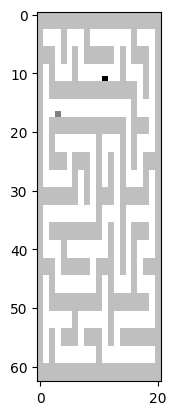

x stretch: 1 y stretch 3


In [385]:
maze = create_maze(N)
env = MazeEnv(maze, max_steps=1000)
env.render()

state, reward, terminated, truncated, info = env.step(0)
print("x stretch:", env.t0,"y stretch",env.t1)

In [386]:
# State Space
thetas = [(i,j) for i in range(1,M) for j in range(1,M)]

# Belief Space b:space -> probability
belief = np.ones(len(thetas))/len(thetas)
b = {theta: belief[i] for i, theta in enumerate(thetas)}

# Obaservation Space (all possible 5-tuples of 0s and 1s)
ob = itertools.product([0,1], repeat=5)
observations = []
for obs in ob:
    observations.append(obs)

orientations = [0,1,2,3]

print("State Space - thetas: ", thetas)
print("observations: ", observations)
print("orientations: ", orientations)
print("belief b_0: ", b)


State Space - thetas:  [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4)]
observations:  [(0, 0, 0, 0, 0), (0, 0, 0, 0, 1), (0, 0, 0, 1, 0), (0, 0, 0, 1, 1), (0, 0, 1, 0, 0), (0, 0, 1, 0, 1), (0, 0, 1, 1, 0), (0, 0, 1, 1, 1), (0, 1, 0, 0, 0), (0, 1, 0, 0, 1), (0, 1, 0, 1, 0), (0, 1, 0, 1, 1), (0, 1, 1, 0, 0), (0, 1, 1, 0, 1), (0, 1, 1, 1, 0), (0, 1, 1, 1, 1), (1, 0, 0, 0, 0), (1, 0, 0, 0, 1), (1, 0, 0, 1, 0), (1, 0, 0, 1, 1), (1, 0, 1, 0, 0), (1, 0, 1, 0, 1), (1, 0, 1, 1, 0), (1, 0, 1, 1, 1), (1, 1, 0, 0, 0), (1, 1, 0, 0, 1), (1, 1, 0, 1, 0), (1, 1, 0, 1, 1), (1, 1, 1, 0, 0), (1, 1, 1, 0, 1), (1, 1, 1, 1, 0), (1, 1, 1, 1, 1)]
orientations:  [0, 1, 2, 3]
belief b_0:  {(1, 1): np.float64(0.0625), (1, 2): np.float64(0.0625), (1, 3): np.float64(0.0625), (1, 4): np.float64(0.0625), (2, 1): np.float64(0.0625), (2, 2): np.float64(0.0625), (2, 3): np.float64(0.0625), (2, 4): np.float64(0.0625), (3, 1): np.float64(0.0

In [387]:

for i in trange(iters):

    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    # Value - Policy stuff
    # TODO


    # Belief update
    pr_o_s = {theta: obs_fun(observation['agent_observations'],observation['agent_orientation'],theta,env.original_maze) for theta in thetas}
    
    eta = np.sum([b[theta] * pr_o_s[theta] for theta in thetas])

    b_o_a = {theta: pr_o_s[theta]*b[theta]/eta for theta in thetas}
    b = b_o_a
    
    assert (np.sum(list(b.values()))-1) < 0.01

    if terminated or truncated:
        observation, info = env.reset()
        belief = np.ones(len(thetas))/len(thetas)
        b = {theta: belief[i] for i, theta in enumerate(thetas)}

        print("NEWMAZE")


env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


In [388]:
b

{(1, 1): np.float64(0.0),
 (1, 2): np.float64(0.0),
 (1, 3): np.float64(0.999682650567072),
 (1, 4): np.float64(0.00031734943292803877),
 (2, 1): np.float64(0.0),
 (2, 2): np.float64(0.0),
 (2, 3): np.float64(0.0),
 (2, 4): np.float64(0.0),
 (3, 1): np.float64(0.0),
 (3, 2): np.float64(0.0),
 (3, 3): np.float64(0.0),
 (3, 4): np.float64(0.0),
 (4, 1): np.float64(0.0),
 (4, 2): np.float64(0.0),
 (4, 3): np.float64(0.0),
 (4, 4): np.float64(0.0)}

In [389]:
env.t0, env.t1

(1, 3)